In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#from sklearn import datasets
#from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from sklearn.model_selection import StratifiedKFold

#from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from fancyimpute import KNN 

In [2]:
df = pd.read_csv('total1112.csv')

In [3]:
df.shape

(37515, 133)

In [4]:
df.columns

Index(['Pseudo_ClientID', 'day_counts_max', 'day_counts_min',
       'day_counts_mean', 'day_counts_count', 'day_counts_std', 'Issue_YN',
       'weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday',
       ...
       'JOB_COUNT', 'LOCATION_COUNT', 'ORG_UNIT_COUNT', 'PAYRUN_COUNT',
       'PAY_PERIOD_COUNT', 'POSITION_COUNT', 'WRKR_PAY_COMP_AVG',
       'WRKR_TAX_AVG', 'NULL_COUNT', 'knn_label'],
      dtype='object', length=133)

In [5]:
len(df[df['Issue_YN']==0])/len(df[df['Issue_YN']==1])

17.08823529411765

In [6]:
dtrain_1=xgb.DMatrix(df.drop(['Pseudo_ClientID','Issue_YN'],axis = 1),label=df['Issue_YN'])

In [31]:
def evalerror_f1(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'f1-score', f1_score(labels, y_bin)

def evalerror_recall(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'Recall_score', recall_score(labels, y_bin)

def evalerror_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'Accuracy', accuracy_score(labels, y_bin)


def evalerror_precision(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'precision_score', precision_score(labels, y_bin)


argsDict={"max_depth" : 10,
          "subsample" : 0.5,
          "min_child_weight" : 1,
          "gamma" : 0.5,
          "reg_lambda" : 0.1,
          "colsample_bytree" : 0.5,
          "n_estimators" : 500,
          #"eval_metric" : 'aucpr',
          "feval" : evalerror,
          "nthread" : 22
          
}


cv_results_f1=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_f1,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

cv_results_recall=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_recall,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

cv_results_accuracy=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_accuracy,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

cv_results_precision=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_precision,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

In [9]:
cv_results_auc=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    metrics='auc',
    #feval=evalerror,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

In [57]:
cv_results_recall['test-Recall_score-mean'].max()

0.43460400000000005

In [51]:
cv_results_accuracy['test-Accuracy-mean'].max()

0.9503132000000001

In [49]:
cv_results_precision['test-precision_score-mean'].max()

0.5689366

In [46]:
cv_results_auc['test-auc-mean'].max()

0.9054401999999999

In [57]:
cv_results["test-f1-score-mean"].max()

0.4815932

# using Scale_pos_weight

In [58]:
def evalerror_f1(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'f1-score', f1_score(labels, y_bin)

def evalerror_recall(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'Recall_score', recall_score(labels, y_bin)

def evalerror_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'Accuracy', accuracy_score(labels, y_bin)


def evalerror_precision(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a colon (:) or a space
    # since preds are margin(before logistic transformation, cutoff at 0)
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in preds]
    #print(labels)
    #print(preds)
    #print(int(1))
    return 'precision_score', precision_score(labels, y_bin)

argsDict={"max_depth" : 14,
          "subsample" : 0.5,
          "min_child_weight" : 1,
          "gamma" : 0.5,
          "reg_lambda" : 0.1,
          "colsample_bytree" : 0.5,
          "n_estimators" : 800,
          #"eval_metric" : 'aucpr',
          "feval" : evalerror,
          "nthread" : 22,
          "scale_pos_weight" : 17.08823529411765         
}



cv_results_f1=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_f1,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

cv_results_recall=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_recall,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

cv_results_accuracy=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_accuracy,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

cv_results_precision=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    #metrics='aucpr',
    feval=evalerror_precision,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

In [62]:
cv_results_auc=xgb.cv(
    argsDict,
    dtrain_1,
    num_boost_round=800,
    nfold=5,
    metrics='auc',
    #feval=evalerror,
    early_stopping_rounds=50,
    verbose_eval=False,
    seed=1)

In [63]:
cv_results_auc

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.951743,0.000973,0.922211,0.003857


In [59]:
cv_results_precision['test-precision_score-mean'].max()

0.448406

In [60]:
cv_results_accuracy['test-Accuracy-mean'].max()

0.9364253999999999

In [61]:
cv_results_f1["test-f1-score-mean"].max()

0.5305806000000001

In [44]:
cv_results_recall['test-Recall_score-mean'].max()

0.43460400000000005

# using Dmatrix to assign weight to samples

In [ ]:
dtrain_1=xgb.DMatrix(df.drop(['Pseudo_ClientID','Issue_YN'],axis = 1),label=df['Issue_YN'],)

# Feature importance

In [65]:
xgboost = xgb.XGBClassifier(max_depth= 14,
          subsample= 0.5,
          min_child_weight=1,
          gamma=0.5,
          reg_lambda=0.1,
          colsample_bytree=0.5,
          n_estimators= 800,
          #"eval_metric" : 'aucpr',
          feval= evalerror,
          nthread= 22,
          scale_pos_weight= 17.08823529411765  )

xgboost.fit(df.drop(['Pseudo_ClientID','Issue_YN'],axis = 1),df['Issue_YN'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, feval=<function evalerror at 0x2b55c1e95d08>,
       gamma=0.5, learning_rate=0.1, max_delta_step=0, max_depth=14,
       min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
       nthread=22, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=17.08823529411765,
       seed=None, silent=True, subsample=0.5)

In [66]:
feature_list = df.drop(['Pseudo_ClientID','Issue_YN'],axis = 1).columns
feature_list_dict = dict(zip(feature_list,np.log1p(xgboost.feature_importances_)))

In [67]:
importances = pd.DataFrame()
importances['Feature'] = feature_list
importances['Importance'] = np.log1p(xgboost.feature_importances_)

In [68]:
importances[importances['Feature']=='knn_label']

,Feature,Importance
130,knn_label,0.000054


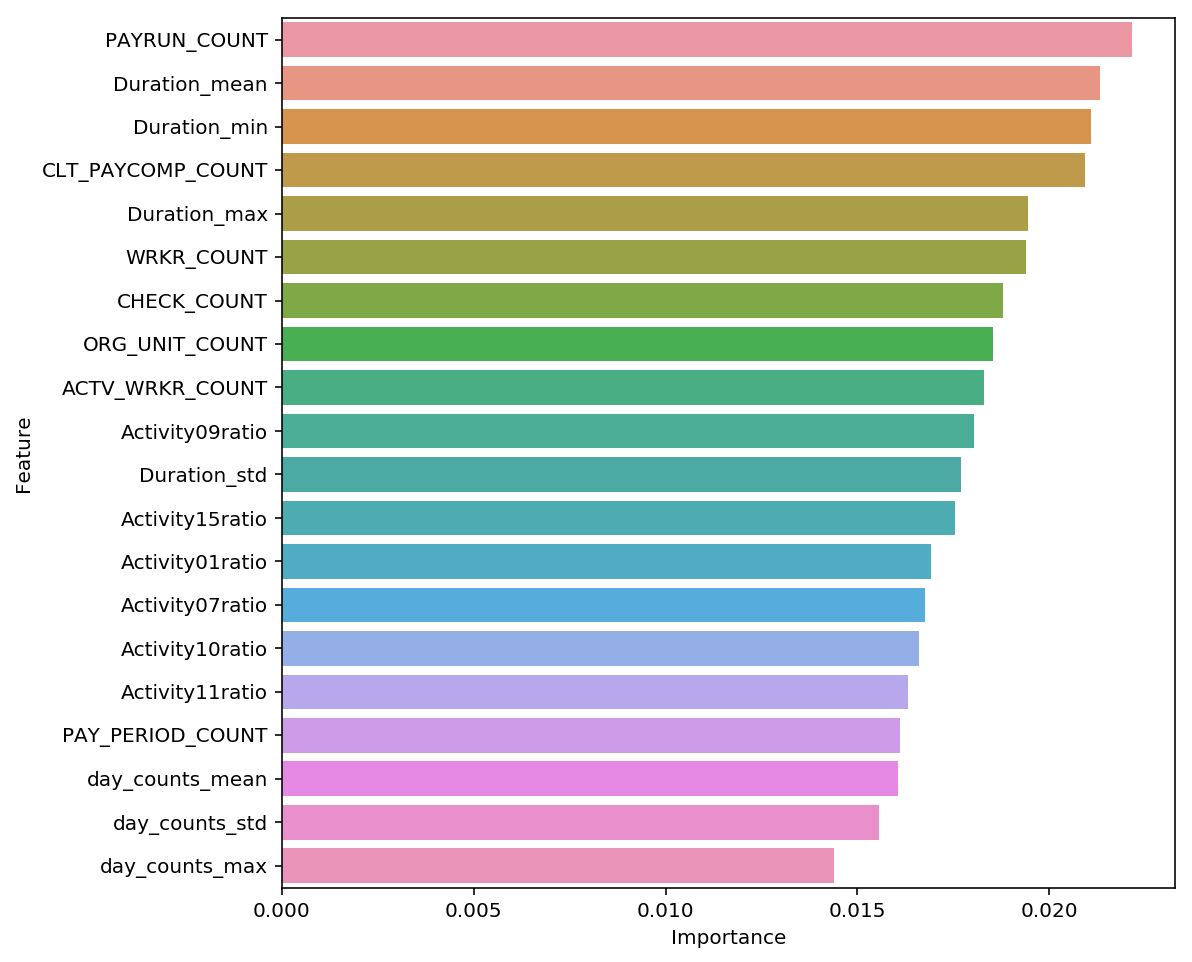

In [71]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

# 这句话就没有用到过啊！！！！！！没有用到过"gain_log"
#importances['gain_log'] = np.log1p(importances['gain'])
#mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
#importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 8))
sns.barplot(x='Importance', y='Feature', data=importances.sort_values('Importance', ascending=False)[:20])
plt.show()